# Approximate Kurtosis Portfolio Optimization

In this notebook we show how to use the semidefinite cone and second order cone to model the optimization of portfolio kurtosis.

## 1. Approximate Kurtosis Minimization

The minimization of portfolio kurtosis can be approximated, as shown in __[Cajas (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4472793)__, as a convex optimization problem as follows:

$$
\begin{equation}
\begin{aligned}
& \min_{x} & &  \left \| g  \right \|_{2}  & \\
& \text{s.t.} & & \left [ \begin{array}{cc} X & x \\ x^{\prime} & 1 \end{array} \right ] \succeq 0 &\\
& & & g_{i} = \text{Tr}\left ( B_{i} X \right ) & \forall i=1, \ldots , K \\
& & & \sum^{n}_{i=1} x_{i} = 1 & \\
& & & x \geq 0 & \\
& & & X = X^{\prime} & \\
\end{aligned}
\end{equation}
$$

where:
<br>$x$: is the vector of portfolio weights of size $n \times 1$
<br>$X$: is an auxiliary variable of size $n \times n$ that is positive symmetric.
<br>$K$: is the number of matrixes $B_{i}$ that are considered in the approximation of kurtosis, I recommend $K=2n$.
<br>$B_{i} =  \left ( \text{vec} \left(I_{n} \right )^{\prime} \otimes I_m \right)(I_n \otimes \sqrt{\lambda_{i}} q_{i}) = \text{vec}^{-1} \left ( \sqrt{\lambda_{i}} q_{i} \right )$.
<br>$\text{vec}$: is the vectorization operator.
<br>$I_{n}$: is the identity matrix of size $n \times n$.
<br>$\lambda_{i}$: is the eigenvalue $i$ of matrix $\text{vec}^{n,n} \left ( \Sigma_{4} \right )$.
<br>$\Sigma_{4}$: is the cokurtosis square matrix.
<br>$\text{vec}^{n,n}(.)$ is the rearrangement operator or block vectorization operator defined in __[Loan (1992)](https://ecommons.cornell.edu/handle/1813/5484)__ and __[Ojeda (2015)](https://arxiv.org/abs/1310.8149)__.

In [2]:
####################################
# Downloading Data
####################################
!pip install --quiet yfinance

import numpy as np
import pandas as pd
import yfinance as yf
from itertools import permutations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2021-12-30'

# Tickers of assets
assets = ['TGT', 'CMCSA', 'CPB', 'MO', 'T', 'BAX', 'BMY',
          'MSFT', 'SEE', 'VZ', 'CNP', 'NI', 'GE', 'GOOG']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.head())

[*********************100%%**********************]  14 of 14 completed


,BAX,BMY,CMCSA,CNP,CPB,GE,GOOG,MO,MSFT,NI,SEE,T,TGT,VZ
Date,,,,,,,,,,,,,,
2016-01-05,0.4036%,1.9693%,0.0179%,0.9305%,0.3678%,0.0977%,0.0998%,2.0213%,0.4562%,1.5881%,0.9758%,0.6987%,1.7539%,1.3734%
2016-01-06,0.2411%,-1.7556%,-0.7727%,-1.2473%,-0.1736%,-1.5940%,0.1400%,1.0589%,-1.8165%,0.5547%,-1.5647%,0.3108%,-1.0155%,-0.9034%
2016-01-07,-1.6573%,-2.7699%,-1.1047%,-1.9770%,-1.2206%,-4.2314%,-2.3170%,-1.7408%,-3.4783%,-2.2066%,-3.1557%,-1.6148%,-0.2700%,-0.5492%
2016-01-08,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5706%,-1.7950%,-1.6410%,0.1720%,0.3067%,-0.1538%,-0.1448%,0.0895%,-3.3839%,-0.9719%
2016-01-11,-1.6850%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.4570%,0.2183%,2.0948%,-0.0573%,1.6436%,-0.1450%,1.2224%,1.4570%,0.5800%


In [3]:
####################################
# Auxiliary functions
####################################

# Function that calculates S_4
def kurt_matrix(Y):
    P = Y.to_numpy()
    T, n = P.shape
    mu = np.mean(P, axis=0).reshape(1,-1)
    mu = np.repeat(mu, T, axis=0)
    x = P - mu
    ones = np.ones((1,n))
    z = np.kron(ones, x) * np.kron(x, ones);
    S4 = 1/T * z.T @ z
    return S4

# Function that calculates block vectorization operator
def block_vec_pq(A, p, q):
    mp, nq = A.shape
    if mp % p == 0 and nq % q == 0:
        m = int(mp / p)
        n = int(nq / q)
        bvec_A = np.empty((0, p * q))
        for j in range(n):
            Aj = np.empty((0, p * q))
            for i in range(m):
                Aij = (
                    A[i * p : (i + 1) * p, j * q : (j + 1) * q]
                    .reshape(-1, 1, order="F")
                    .T
                )
                Aj = np.vstack([Aj, Aij])
            bvec_A = np.vstack([bvec_A, Aj])
    return bvec_A

In [4]:
##################################################
# Finding the Min Approximate Kurtosis Portfolio
##################################################

import cvxpy as cp
#import mosek
from scipy.linalg import sqrtm

# Parameters
T, n = Y.shape
K = 2*n

# Calculate square cokurtosis matrix
Sigma_4 = kurt_matrix(Y)

# Calculate block vectorization of square cokurtosis matrix
A = block_vec_pq(Sigma_4, n, n)
# Finding eigenvalues and eigenvectors
s_A, V_A = np.linalg.eig(A)
s_A = np.clip(s_A, 0, np.inf)
# Calculating matrixes Bi
Bi = []
for i in range(K):
    B = s_A[i] ** 0.5 * V_A[:, i]
    B = B.reshape((n, n), order="F").real
    Bi.append(B)

# Variables
rows = int(n*(n+1)/2)
x = cp.Variable((n,1))
z = cp.Variable((rows,1))
X = cp.Variable((n,n), PSD=True)
g = cp.Variable((K, 1))

risk = cp.pnorm(g,p=2)
M = cp.bmat([[X, x], [x.T, np.ones((1, 1))]])
constraints = [cp.sum(x) == 1,
               x >= 0,
               M >> 0]

for i in range(K):
    constraints += [g[i, 0] == cp.trace(Bi[i] @ X)]

obj = cp.Minimize(risk * 1000)
prob = cp.Problem(obj, constraints)

#prob.solve(solver='MOSEK', mosek_params= {mosek.iparam.num_threads: 2})
prob.solve()
w = pd.DataFrame(x.value, index=assets, columns=['weights'])
display(w)

,weights
BAX,-0.0000%
BMY,20.5570%
CMCSA,-0.0000%
CNP,-0.0000%
CPB,19.6940%
GE,-0.0000%
GOOG,4.2226%
MO,-0.0000%
MSFT,-0.0000%
NI,-0.0000%


In [5]:
####################################
# Finding the Min Variance Portfolio
####################################

!pip install --quiet riskfolio-lib
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.solvers = [cp.MOSEK]
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be EVaR
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w2 = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w2)

The problem doesn't have a solution with actual input parameters


None

In [6]:
####################################
# Montecarlo Simulation
####################################

# Montecarlo simulation of portfolio weights
rs = np.random.RandomState(seed=123)
s1 = rs.dirichlet([0.1] * len(assets), 10000)
s2 = rs.dirichlet([0.25] * len(assets), 10000)
s3 = rs.dirichlet([0.5] * len(assets), 10000)
s4 = rs.dirichlet([0.75] * len(assets), 10000)
s5 = rs.dirichlet([1.0] * len(assets), 10000)
s6 = rs.dirichlet([1.5] * len(assets), 10000)
s7 = rs.dirichlet([2.0] * len(assets), 10000)
s8 = rs.dirichlet([3.0] * len(assets), 10000)
sample = np.concatenate([np.identity(len(assets)), s1, s2, s3, s4, s5, s6, s7, s8], axis=0)

# Calculating mean, standard deviation and square root kurtosis of each portfolio
m = sample.shape[0]
M_1 = np.mean(Y.to_numpy(), axis=0).reshape(1,-1)
M_2 = Y.cov().to_numpy()

c_mean = M_1 @ sample.T
c_var = np.zeros(m)
c_kurt = np.zeros(m)

for i in range(0, m):
    c_var[i] = (sample[i] @ M_2 @ sample[i].T) ** (0.5)
    c_kurt[i] = (np.kron(sample[i], sample[i]) @ Sigma_4 @ np.kron(sample[i],sample[i]).T) ** (1/4)

AttributeError: 'NoneType' object has no attribute 'to_numpy'

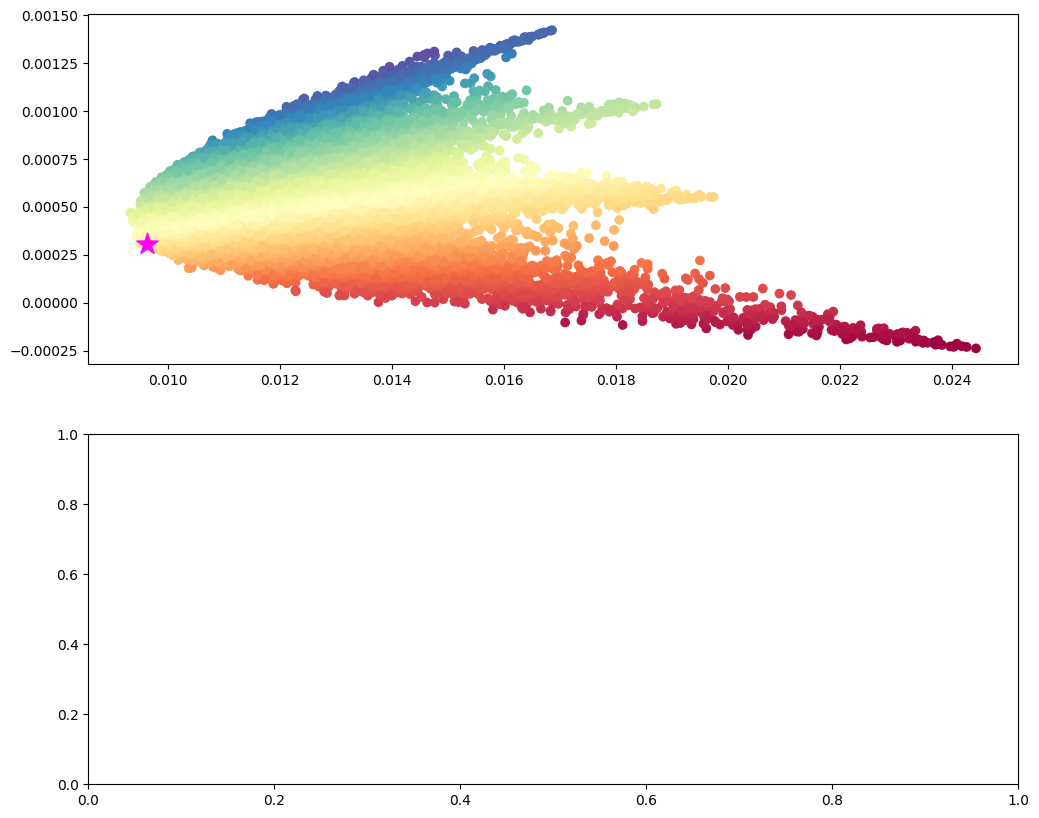

In [7]:
####################################
# Plotting Portfolios
####################################

fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax = np.ravel(ax)

# Plotting Portfolios in mean-standard deviation plane
cax0 = ax[0].scatter(c_var, c_mean, c=c_mean/c_var, cmap='Spectral')
ax[0].scatter((w.to_numpy().T @ M_2 @ w.to_numpy()) ** (0.5),
              M_1 @ w.to_numpy(),
              marker='*',
              s=2**8,
              color='fuchsia',
              label='Minimum Approximate Kurtosis')
ax[0].scatter((w2.to_numpy().T @ M_2 @ w2.to_numpy()) ** (0.5),
              M_1 @ w2.to_numpy(),
              marker='*',
              s=2**8,
              color='tab:red',
              label='Minimum Variance')

# Plotting Portfolios in mean-square root kurtosis plane
cax1 = ax[1].scatter(c_kurt, c_mean, c=c_mean/c_kurt**2, cmap='Spectral')
ax[1].scatter((np.kron(w.to_numpy(), w.to_numpy()).T @ Sigma_4 @ np.kron(w.to_numpy(), w.to_numpy())) ** (0.25),
              M_1 @ w.to_numpy(),
              marker='*',
              s=2**8,
              color='fuchsia',
              label='Minimum Approximate Kurtosis')
ax[1].scatter((np.kron(w2.to_numpy(), w2.to_numpy()).T @ Sigma_4 @ np.kron(w2.to_numpy(), w2.to_numpy())) ** (0.25),
              M_1 @ w2.to_numpy(),
              marker='*',
              s=2**8,
              color='tab:red',
              label='Minimum Variance')

fig.colorbar(cax0, ax=ax[0], label='Expected Return / Standard Deviation')
fig.colorbar(cax1, ax=ax[1], label='Expected Return / Square Root Kurtosis')

ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].set_xlabel('Daily Standard Deviation')
ax[0].set_ylabel('Daily Espected Return')
ax[0].legend()

ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].set_xlabel('Daily Fourth Root Kurtosis')
ax[1].set_ylabel('Daily Espected Return')
ax[1].legend()

fig.tight_layout()

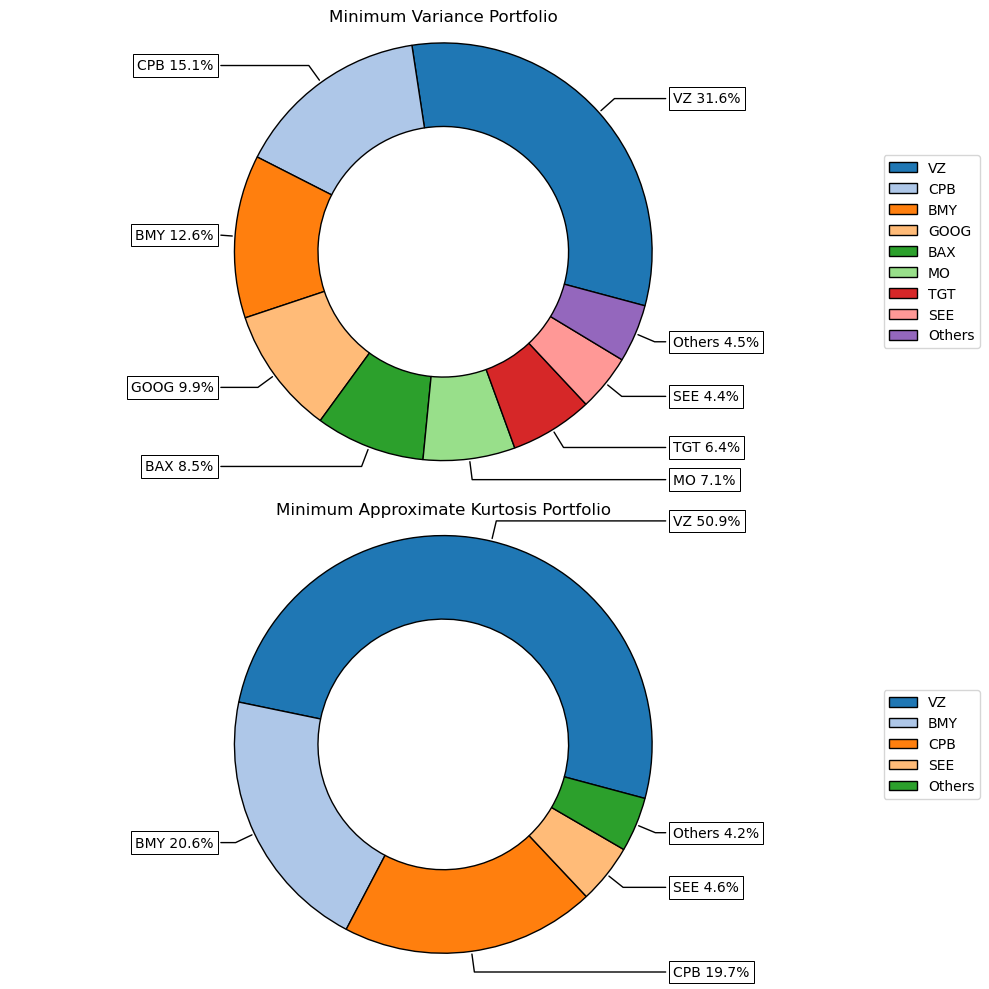

In [ ]:
####################################
# Plotting Portfolios Composition
####################################

fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax = np.ravel(ax)

rp.plot_pie(w=w2,
            title='Minimum Variance Portfolio',
            others=0.05,
            nrow=25,
            ax=ax[0])

rp.plot_pie(w=w,
            title='Minimum Approximate Kurtosis Portfolio',
            others=0.05,
            nrow=25,
            ax=ax[1])

fig.tight_layout()

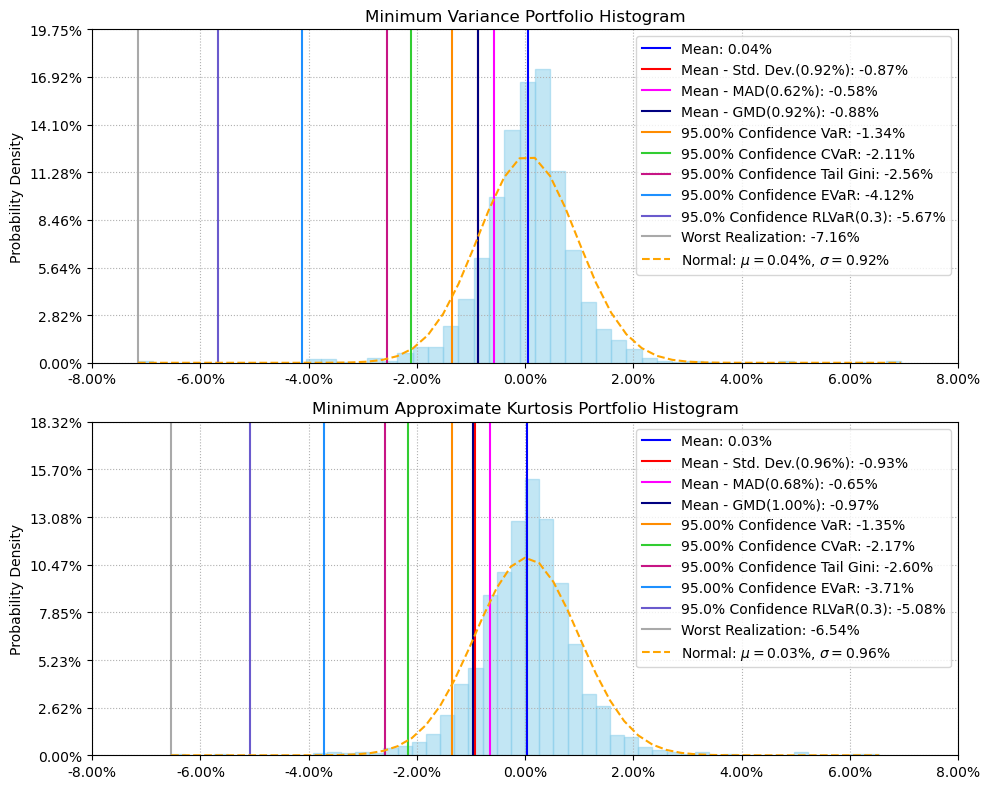

In [ ]:
####################################
# Plotting Portfolios Histogram
####################################

fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax = np.ravel(ax)

rp.plot_hist(returns=Y,
             w=w2,
             alpha=0.05,
             bins=50,
             ax=ax[0])

rp.plot_hist(returns=Y,
             w=w,
             alpha=0.05,
             bins=50,
             ax=ax[1])

ax[0].set_title('Minimum Variance Portfolio Histogram')
ax[1].set_title('Minimum Approximate Kurtosis Portfolio Histogram')

fig.tight_layout()

We can see that the minimum approximate kurtosis portfolio reduce the tails of portfolio returns distribution compared to minimun variance portfolio because more conservative downside risk measures like Entropic Value at Risk and Worst realization are lower for the minimum kurtosis portfolio.

This portfolio optimization model is available in the CVXPY based library __[Riskfolio-Lib](https://github.com/dcajasn/Riskfolio-Lib)__.

Finally, I hope you liked this example.